making catalogues to test within eazy
opens ZFOURGE cat file, prepares it for dataframe, and some different catalogues are made (binning and such)
then these are saved and can be used within the eazy code
Best to run this as separate cells, specified to your requirements

In [18]:
import global_settings
%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import time
import importlib
import sys
import eazy
import astropy.stats
import global_settings as gs

output = 'inputs/alternate_catalogues/'

## Importing Template files into col1: $\lambda$ A, col2: flux$\lambda$

In [72]:
# Adapting Template Files for EAZY

# Set the directory
in_dir = 'G:/AGN/hlsp_agnsedatlas_multi_multi_all_multi_v1_collection/templates_restframe/'
# out_dir = 'C:/Users/eddie/PycharmProjects/SEDTemplate_conda/templates/hlsp_agnsedatlas_rest/'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Get the txt files  in the directory
txt_files = glob.glob(in_dir + '*.txt')

#txt_files = [i for i in txt_files if 'central' in i] # If you want the composite files
txt_files = [i for i in txt_files if '-central-' not in i] # If you don't want the composite files

for idi, i in enumerate(txt_files):

    print(idi)
    # Read the txt file
    data = pd.read_csv(i, sep=" ", comment='#', header=None, skipinitialspace=True)

    data[0] = data[0] * 1e4 # Convert the wavelength from Micron to Angstroms
    if idi == 11:
        # the second column of 11 is Luminosity in W/Hz, so we need to convert it to flux in erg/s/cm^2/A

        redshift_of_object = 0.13288

        # redshift to distance
        distance = (redshift_of_object * 3e5) / 70 # Hubble constant is 70 km/s/Mpc, and c is 3e5 km/s. The distance is in Mpc
        distance = distance * 3.086e24 # convert to cm

        data[2] = data[1] / (4 * np.pi * distance**2) # convert to flux density // IS A LINEAR SCALE AND IS NOT NEEDED
        data[2] = data[2] * 3e18 / data[0] ** 2#  W/Hz/cm^2 to W/cm^2/A
        data[2] = data[2] * 1e7 # W/A/cm^2 to erg/s/cm^2/A // IS A LINEAR SCALE AND IS NOT NEEDED




    output_data = data[[0,2]]

    # Get the base name of the txt file
    base_name = os.path.basename(os.path.splitext(i)[0])

    # Write the selected data to a dat file
    output_data.to_csv(out_dir + f'{base_name}.dat', sep=' ', index=False, header=False)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


## Making a combined catalogue

In [ ]:
# Making any combined catalogues that cross multiple fields

fields  = ['cdfs', 'cosmos', 'uds']

main_dir_combined = []
main_combined_all = []
translate_all = []

for idx, field in enumerate(fields):
    all_catalogues = glob.glob(f'zfourge/{field}/{field}*.cat')

        # Check if any files were found
    if not all_catalogues:
      print(f"No .cat files found for {field}")
    else:
      # Find the shortest file by filename
      main_dir_combined.append(min(all_catalogues, key=len))

    main = pd.read_csv(main_dir_combined[idx], sep=" ", comment="#", header=None)
    headers = pd.read_csv(main_dir_combined[idx], sep=" ", header=None, nrows=1).iloc[0]
    headers = headers[1:]
    main.columns = headers

    agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat') # This is the agn file
    agn = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)
    headers = ['id', 'ir_agn', 'radio_agn','xray_agn']
    agn.columns = headers


    merged = pd.merge(main, agn, on='id', how='left')
    unwanted_hash = pd.Series(np.nan, index=merged.index, dtype=float)
    merged.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start

    main_combined_all.append(merged)

    # Also need to make a new translate file
    translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate') # again this glob function will need some customisation
    translate = pd.read_csv(translate_file[0], sep='\s+', header=None, usecols=range(2))
    translate_all.append(translate)

main_combined = pd.concat(main_combined_all, ignore_index=True)
main_combined['id'] = main_combined.index + 1

translate_final = pd.concat(translate_all, ignore_index=True)
translate_final = translate_final.drop_duplicates(keep='first')

In [ ]:
if not os.path.isdir('zfourge/combined/eazy'):
    os.makedirs('zfourge/combined/eazy')

translate_final.to_csv('zfourge/combined/eazy/combined.1.0.translate', sep=' ', index=False)

In [ ]:
# Columns to exclude
exclude_cols = ['#']
# Replace NaN with -99 for all columns except excluded columns
main_combined.loc[:, ~main_combined.columns.isin(exclude_cols)] = main_combined.loc[:, ~main_combined.columns.isin(exclude_cols)].fillna(-99)

# move agn columns to the end so that nan values are not in the middle of the file
agn_cols = ['star', 'nearstar', 'use', 'snr', 'use_nosnr', 'z_spec', 'ir_agn', 'radio_agn', 'xray_agn']

main_combined = main_combined[[col for col in main_combined if col not in agn_cols] + [col for col in agn_cols]]
main_combined.to_csv(f'{output}combined.normal.cat', sep=' ', index=False)

## Feeding in new spec z values from other catalogues

In [13]:
field = 'cdfs' # field you want to merge with

# Get all cat files
all_files = glob.glob(f'zfourge/{field}/{field}*.cat')

# Check if any files were found
if not all_files:
  print("No .cat files found")
else:
  # Find the shortest file by filename
  main_dir = min(all_files, key=len)

main = pd.read_csv(main_dir, sep=" ", comment="#", header=None)
headers = pd.read_csv(main_dir, sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

input_xmatches = f'G:/honours/{field}2 crossmatched/' # this is the naming convention for the x matched files
all_xmatch  = glob.glob(f'{input_xmatches}*.csv')
possible_columns = ['z_spec', 'zspec_2', 'z']
all_spec_z = pd.DataFrame({'id': main['id']})

for xmatch in all_xmatch:
    xmatch_data = pd.read_csv(xmatch)
    xmatch_df = pd.DataFrame(columns=['id', f'z_spec{xmatch}'])
    try:
        xmatch_df['id'] = xmatch_data['Seq_1']
    except KeyError:
        xmatch_df['id'] = xmatch_data['Seq']
    for col in possible_columns:
        if col in xmatch_data .columns:
            xmatch_df[f'z_spec{xmatch}'] = xmatch_data[col]
            break
    all_spec_z = pd.merge(all_spec_z, xmatch_df, on='id', how='left')

only_spec_z = all_spec_z.drop(columns='id')
all_spec_z['z_spec'] = only_spec_z.bfill(axis=1).iloc[:, 0]
print(len(main[(main['z_spec'] > 0)]['z_spec']))
main.replace(-99, np.nan, inplace=True)
main['z_spec'] = main['z_spec'].combine_first(all_spec_z['z_spec'])
main.replace(np.nan, -99, inplace=True)
print(len(main[(main['z_spec'] > 0)]['z_spec']))
unwanted_hash = pd.Series(np.nan, index=main.index, dtype=float)
main.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start

ValueError: Length mismatch: Expected axis has 158 elements, new values have 157 elements

In [17]:
#main.to_csv(f'{output}{field}2.normal.cat', sep=' ', index=False)

## Start here if you are trimming the catalogue

In [86]:
# Load the catalogues

os.getcwd()

field = 'uds'

# Get all cat files
all_files = glob.glob(f'zfourge/{field}/{field}*.cat')

# Check if any files were found
if not all_files:
  print("No .cat files found")
else:
  # Find the shortest file by filename
  main_dir = min(all_files, key=len)

main = pd.read_csv(main_dir, sep=" ", comment="#", header=None, skipinitialspace=True)
headers = pd.read_csv(main_dir, sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
try:
    main.columns = headers
except ValueError: # if there is a space infront of the id value
    main.iloc[:, 1:].columns = headers

agn_data1 = glob.glob(f'zfourge/{field}/{field}.v*.agn.*cat')
agn = pd.read_csv(agn_data1[0], sep="\s+", comment='#', header=None)
headers = ['id', 'ir_agn', 'radio_agn','xray_agn']
agn.columns = headers


merged = pd.merge(main, agn, on='id', how='left')
unwanted_hash = pd.Series(np.nan, index=merged.index, dtype=float)
merged.insert(loc=0, column='#', value=unwanted_hash) #wierd hash at the start
mean_RA = merged['ra'].mean()
mean_DEC = merged['dec'].mean()
print(f'The mean RA is {mean_RA} and the mean DEC is {mean_DEC}')

The mean RA is 34.318195942149096 and the mean DEC is -5.201751693835152


In [74]:
range_RA = merged['ra'].max() - merged['ra'].min()
range_DEC = merged['dec'].max() - merged['dec'].min()
print(f'The range of RA is {range_RA} degrees and the range of DEC is {range_DEC} degrees')

The range of RA is 0.2305716999999987 degrees and the range of DEC is 0.229908 degrees


Saving the Catalogue file

In [55]:
merged.to_csv(f'{output}{field}.normal.cat', sep=' ', index=False)

Use Flag Cuts

In [56]:
useflag_df  = merged[merged['use'] == 1]
useflag_df.to_csv(f'{output}{field}.useflag.cat', sep=' ', index=False)
print(f'the size of this dataframe is: {len(useflag_df)}')

the size of this dataframe is: 13299


Doing Specific Range Cuts

In [ ]:
object_range = (0,-0)
new_cat = merged[object_range[0]:object_range[1]]
new_cat.to_csv(f'{output}{field}.range.{object_range}.cat', sep=' ', index=False)

Doing Standard AGN Type Cuts, AGN type (Or wavelength) is not really as useful as the fraction of AGN

In [75]:
# ir_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0)]
# radio_cut = merged[(merged['radio_agn'] == 1) & (merged['z_spec'] > 0)]
# xray_cut = merged[(merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# all_cut = merged[(merged['ir_agn'] == 1) & (merged['z_spec'] > 0) | (merged['radio_agn'] == 1) & (merged['z_spec'] > 0) | (merged['xray_agn'] == 1) & (merged['z_spec'] > 0)]
# nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1) & (merged['z_spec'] > 0)]

ir_cut = merged[(merged['ir_agn'] == 1)]
radio_cut = merged[(merged['radio_agn'] == 1)]
xray_cut = merged[(merged['xray_agn'] == 1)]
all_cut = merged[(merged['ir_agn'] == 1) | (merged['radio_agn'] == 1) | (merged['xray_agn'] == 1)]
nothing_cut = merged[(merged['ir_agn'] != 1) & (merged['radio_agn'] != 1) & (merged['xray_agn'] != 1)]

ir_cut.to_csv(f'{output}{field}.ir_agn.cat', sep=' ', index=False)
radio_cut.to_csv(f'{output}{field}.radio_agn.cat', sep=' ', index=False)
xray_cut.to_csv(f'{output}{field}.xray_agn.cat', sep=' ', index=False)
all_cut.to_csv(f'{output}{field}.all_agn.cat', sep=' ', index=False)
nothing_cut.to_csv(f'{output}{field}.no_agn.cat', sep=' ', index=False)

Reading the AGN Fraction file, and slimming it down, and creating keys from it

In [89]:
# Read the CIGALE results file
agn_per_dir = f'inputs/{field}_results.txt' # large file
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

In [ ]:
new_bayes = all_bayes[['id', 'bayes.agn.fracAGN', 'bayes.agn.fracAGN_err', 'bayes.agn.luminosity']] # this is the information I want from this file
new_bayes.to_csv(f'inputs/{field}_agn_frac.txt', sep=' ', index=False)

In [ ]:
#making combined bayes file
all_agn_data = []
for field in fields:
    agn_data = pd.read_csv(f'inputs/{field}_agn_frac.txt', sep="\s+", comment='#')
    all_agn_data.append(agn_data)

all_agn_data = pd.concat(all_agn_data, ignore_index=True)
all_agn_data['id'] = all_agn_data.index + 1
all_agn_data.to_csv(f'inputs/combined_agn_frac.txt', sep=' ', index=False)

Merging the AGN fraction file with the main catalogue

In [87]:
bayes = pd.read_csv(f'inputs/{field}_agn_frac.txt', sep="\s+", comment='#')
merged_bayes = pd.merge(merged, bayes, on='id', how='left')
fraction_sorted = merged_bayes.sort_values(by='bayes.agn.fracAGN', ascending=False)
luminosity_sorted = merged_bayes.sort_values(by='bayes.agn.luminosity', ascending=False)
num_rows = merged_bayes.shape[0]

AGN Bins, usually have 10 bins

In [ ]:
num_bins = 10
fraction_range = 100/num_bins

#split fraction sorted into bins and save each as a separate df

for bin_no in range(num_bins):
    min_bin = (bin_no * fraction_range) / 100
    max_bin = ((bin_no+1) * fraction_range) / 100
    bin_df = fraction_sorted[(min_bin <= fraction_sorted['bayes.agn.fracAGN']) &
                             (fraction_sorted['bayes.agn.fracAGN'] <= max_bin)]
    bin_df.to_csv(f'{output}{field}.fraction.bin{min_bin}to{max_bin}.cat', sep=' ', index=False)



In [84]:
#Only objects with an agn fraction above percent
percent = 0.4
only_agn = merged_bayes[merged_bayes['bayes.agn.fracAGN'] >= percent]
print(len(only_agn))
only_agn.to_csv(f'{output}{field}.only_agn_above_{percent}.cat', sep=' ', index=False)

4873


## Lacy wedge

In [88]:
# set field again
is_it_combined = False
if is_it_combined:
    lacy_init_df = main_combined[['f_IRAC_58', 'e_IRAC_58', 'f_IRAC_36', 'e_IRAC_36', 'f_IRAC_80', 'e_IRAC_80', 'f_IRAC_45', 'e_IRAC_45', 'bayes.agn.fracAGN']]
else:
    lacy_init_df = merged_bayes[['f_IRAC_58', 'e_IRAC_58', 'f_IRAC_36', 'e_IRAC_36', 'f_IRAC_80', 'e_IRAC_80', 'f_IRAC_45', 'e_IRAC_45', 'bayes.agn.fracAGN']]
cut_by_negative_lacy = (lacy_init_df['f_IRAC_58'] > -0) &\
                       (lacy_init_df['f_IRAC_36'] > -0) &\
                       (lacy_init_df['f_IRAC_80'] > -0) &\
                       (lacy_init_df['f_IRAC_45'] > -0)
lacy_init_df = lacy_init_df[cut_by_negative_lacy]

cut_by_error_lacy = (lacy_init_df['f_IRAC_58'] > 3 * lacy_init_df['e_IRAC_58']) &\
                    (lacy_init_df['f_IRAC_36'] > 3 * lacy_init_df['e_IRAC_36']) &\
                    (lacy_init_df['f_IRAC_80'] > 3 * lacy_init_df['e_IRAC_80']) &\
                    (lacy_init_df['f_IRAC_45'] > 3 * lacy_init_df['e_IRAC_45'])

lacy_init_df = lacy_init_df[cut_by_error_lacy]

In [89]:
lacy_df = pd.DataFrame()
lacy_df['58'] = lacy_init_df['f_IRAC_58']
lacy_df['36'] = lacy_init_df['f_IRAC_36']
lacy_df['80'] = lacy_init_df['f_IRAC_80']
lacy_df['45'] = lacy_init_df['f_IRAC_45']
lacy_df['agn'] = lacy_init_df['bayes.agn.fracAGN']

lacy_df['x'] = np.log10(lacy_df['58']/lacy_df['36'])
lacy_df['y'] = np.log10(lacy_df['80']/lacy_df['45'])

cut = (lacy_df['x'] > -0.1) & (-0.2 < lacy_df['y']) & (lacy_df['y'] < (0.8 * lacy_df['x'] + 0.5))
lacy_in = lacy_df[cut]
lacy_out = lacy_df[~cut]

common_index = merged.index.intersection(lacy_in.index)
lacy_cat = merged.loc[common_index]

#lacy_cat.to_csv(f'{output}{field}.lacy_wedge.cat', sep=' ', index=False)
len(lacy_cat)

975

(-1.2, 1.2)

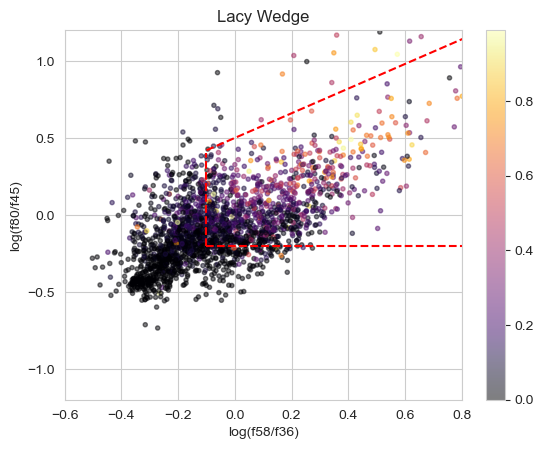

In [90]:
plt.scatter(lacy_in['x'], lacy_in['y'], c=lacy_in['agn'], cmap='inferno', marker='.', alpha=0.5)
plt.scatter(lacy_out['x'], lacy_out['y'], c=lacy_out['agn'], cmap='inferno', marker='.', alpha=0.5)

x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('Lacy Wedge')
plt.colorbar()
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)

In [67]:
cut_donley = (lacy_df['x'] >= 0.08) & (lacy_df['y'] >= 0.15) & (lacy_df['y'] >= (1.21 * lacy_df['x']) - 0.27) & (lacy_df['y'] <= (1.21 * lacy_df['x']) + 0.27) & (lacy_df['80'] > lacy_df['58']) & (lacy_df['58'] > lacy_df['45']) & (lacy_df['45'] > lacy_df['36'])

donley_in = lacy_df[cut_donley]
donley_out = lacy_df[~cut_donley]

common_index = merged.index.intersection(donley_in.index)
lacy_cat = merged.loc[common_index]
#lacy_cat.to_csv(f'{output}{field}.donley_wedge.cat', sep=' ', index=False)

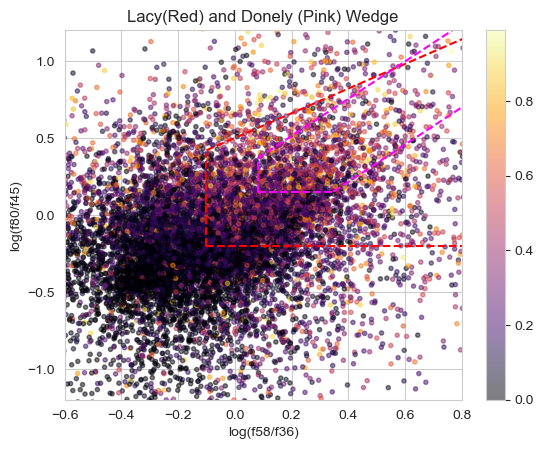

In [68]:
plt.scatter(donley_in['x'], donley_in['y'], c=donley_in['agn'], cmap='inferno', marker='.', alpha=0.5)
plt.scatter(donley_out['x'], donley_out['y'], c=donley_out['agn'], cmap='inferno', marker='.', alpha=0.5)

x_boundary = np.linspace(-0.1, 2, 100)  # Adjust range as needed
y_boundary1 = -0.2 * np.ones_like(x_boundary)
y_boundary2 = 0.8 * x_boundary + 0.5
y_line = np.linspace(-0.2, 0.4, 100)
plt.plot(x_boundary, y_boundary1, color='red', linestyle='--')
plt.plot(x_boundary, y_boundary2, color='red', linestyle='--')
plt.plot(-0.1 * np.ones_like(y_line), y_line, color='red', linestyle='--')

plt.xlabel('log(f58/f36)')
plt.ylabel('log(f80/f45)')
plt.title('Lacy(Red) and Donely (Pink) Wedge')
plt.colorbar()
plt.xlim(-0.6, 0.8)
plt.ylim(-1.2, 1.2)

# Define functions for boundary lines
def line1(x):
    return 1.21 * x - 0.27
def line2(x):
    return 1.21 * x + 0.27

# Generate x values for plotting lines
x_values1 = np.linspace(0.08, max(lacy_df['x']), 100)
x_values2 = np.linspace(0.35, max(lacy_df['x']), 100)

# Plot the lines
plt.plot(x_values2, line1(x_values2), color='magenta', linestyle='--')
plt.plot(x_values1, line2(x_values1), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.35, 10), np.linspace(0.15, 0.15, 10), color='magenta', linestyle='--')
plt.plot(np.linspace(0.08, 0.08, 10), np.linspace(0.15, 0.35, 10), color='magenta', linestyle='--')

Cutting Overlap from N catalogues

In [91]:
# Cutting catalogues by other catalogues
field = 'cosmos2'
catalogues_to_cut = ['xray_agn',  'lacy'] # please use naming convention in the id dictionary
objects_in_cut = pd.DataFrame(columns=['catalog', 'size', 'overlap'])
lengths = []

for cat1 in catalogues_to_cut:

    cat1_dir = global_settings.get_id_dict(field)[cat1]
    cat1_df = pd.read_csv(cat1_dir, sep=' ')
    lengths.append(len(cat1_df))

    cat2_ids = pd.DataFrame(columns=['id'])

    for cat2 in catalogues_to_cut:
        if cat1 != cat2:
            cat2_dir = gs.get_id_dict(field)[cat2] # grabbing the directory
            cat2_df = pd.read_csv(cat2_dir, sep=' ')
            cat2_ids = pd.concat([cat2_ids, cat2_df[['id']]])

    cat2_ids.drop_duplicates(inplace=True)
    cat2_ids.reset_index(drop=True, inplace=True)
    cat2_ids = pd.DataFrame(cat2_ids, columns=['id'])

    # Identify overlapping IDs
    overlapping_ids = pd.merge(cat1_df['id'], cat2_ids['id'], on='id')
    cat1_cut = cat1_df[~cat1_df['id'].isin(overlapping_ids['id'])]
    #cat1_cut.to_csv(f'{output}{field}.{cat1}.no_overlap.cat', sep=' ', index=False)

    data_list = pd.DataFrame({'catalog': cat1, 'overlap': [len(overlapping_ids)]})
    objects_in_cut = pd.concat([objects_in_cut, data_list])

objects_in_cut['size'] = lengths
objects_in_cut.reset_index(drop=True, inplace=True)
objects_in_cut

,catalog,size,overlap
0,xray_agn,73,49
1,lacy,613,49


Text(0.5, 1.0, 'cosmos2 Overlap')

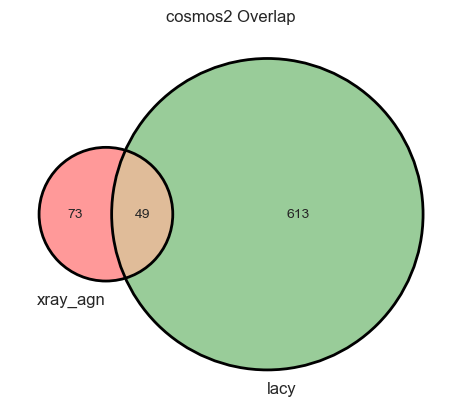

In [93]:
from matplotlib_venn import venn2
from matplotlib_venn import venn2,venn2_circles

# if you've used 2 catalogues
venn2(subsets = (objects_in_cut.loc[0, 'size'], objects_in_cut.loc[1, 'size'], objects_in_cut.loc[0, 'overlap']), set_labels = (objects_in_cut.loc[0, 'catalog'], objects_in_cut.loc[1, 'catalog']))
venn2_circles(subsets=(objects_in_cut.loc[0, 'size'], objects_in_cut.loc[1, 'size'], objects_in_cut.loc[0, 'overlap']))

plt.title(f'{field} Overlap')

In [76]:
objects_in_cut.loc[0, 'size']

0     238
0    2101
Name: size, dtype: int64

Making a synthetic catalogue

In [169]:
input_dir = 'inputs/synthetic_templates/'
all_templates  = glob.glob(f'{input_dir}*.sed')
all_templates

['inputs/synthetic_templates\\Arp220_template_norm.sed',
 'inputs/synthetic_templates\\BQSO1_template_norm.sed',
 'inputs/synthetic_templates\\Ell13_template_norm.sed',
 'inputs/synthetic_templates\\Ell2_template_norm.sed',
 'inputs/synthetic_templates\\Ell5_template_norm.sed',
 'inputs/synthetic_templates\\I19254_template_norm.sed',
 'inputs/synthetic_templates\\I20551_template_norm.sed',
 'inputs/synthetic_templates\\I22491_template_norm.sed',
 'inputs/synthetic_templates\\M82_template_norm.sed',
 'inputs/synthetic_templates\\Mrk231_template_norm.sed',
 'inputs/synthetic_templates\\N6090_template_norm.sed',
 'inputs/synthetic_templates\\N6240_template_norm.sed',
 'inputs/synthetic_templates\\QSO1_template_norm.sed',
 'inputs/synthetic_templates\\QSO2_template_norm.sed',
 'inputs/synthetic_templates\\S0_template_norm.sed',
 'inputs/synthetic_templates\\Sa_template_norm.sed',
 'inputs/synthetic_templates\\Sb_template_norm.sed',
 'inputs/synthetic_templates\\Sc_template_norm.sed',
 'inp

(0.01, 1000.0)

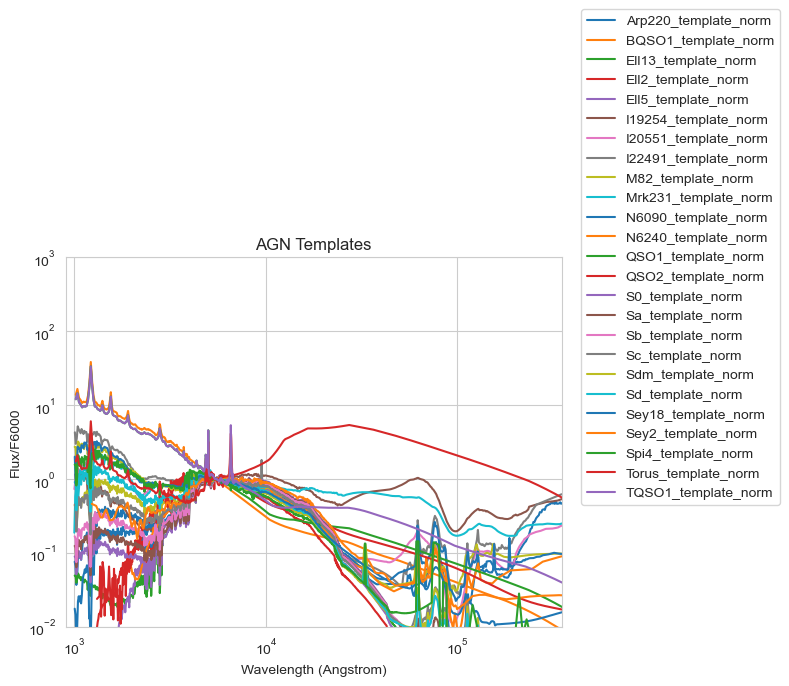

In [170]:
plt.clf()
for template in all_templates:
    template_data = pd.read_csv(template, sep='\s+', header=None)
    id_temp = template.split('\\')[-1].split('.')[0]
    plt.plot(template_data[0], template_data[1], label=id_temp)
plt.legend()
plt.legend(bbox_to_anchor=(1.04, 1), loc="center left", borderaxespad=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux/F6000')
plt.title('AGN Templates')
plt.xlim(900, 35e4)
plt.ylim(1e-2, 1e3)

In [171]:
mrk231 = [s for s in all_templates if "mrk231" in s.lower()]
mrk231 = mrk231[0]
mrk231

'inputs/synthetic_templates\\Mrk231_template_norm.sed'

(0.01, 1000.0)

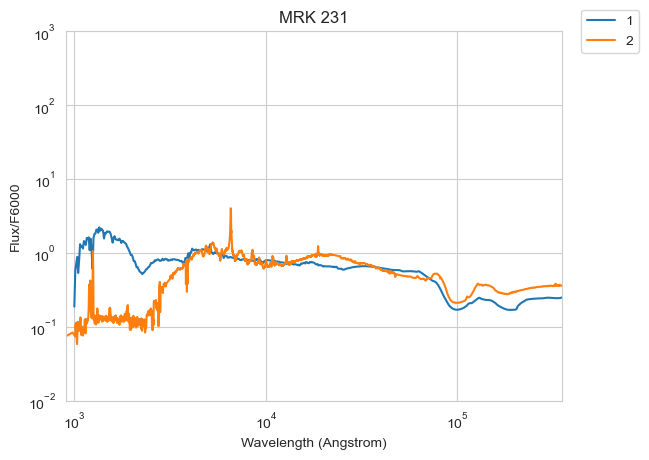

In [172]:
other_dir = 'templates/hlsp_agnsedatlas_rest/'
all_templates  = glob.glob(f'{other_dir}*.dat')
mrk231_2 = [s for s in all_templates if "mrk231" in s]
mrk231_2 = mrk231_2[0]
template_data_1 = pd.read_csv(mrk231, sep='\s+', header=None)
template_data_2 = pd.read_csv(mrk231_2, sep='\s+', header=None)
plt.plot(template_data_1[0], template_data_1[1], label='1')
flux_position =  abs(template_data_2[0] - 6000).idxmin()
flux_normal = template_data_2[1][flux_position]
plt.plot(template_data_2[0], template_data_2[1] / flux_normal, label='2')
plt.legend()
plt.legend(bbox_to_anchor=(1.04, 1), loc="center left", borderaxespad=0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux/F6000')
plt.title('MRK 231')
plt.xlim(900, 35e4)
plt.ylim(1e-2, 1e3)

In [173]:
agn_templates = ['Sey2', 'Sey1.8', 'QSO2', 'Torus', 'QSO1', 'BQSO1', 'TQSO1'] # which of the templates are of AGNs
composite_templates = ['IRAS19254-7245 South ', 'Mrk231'] # which of the templates are composite, and won't be used
galaxy_templates = [n for n in all_templates if n not in agn_templates and n not in composite_templates]

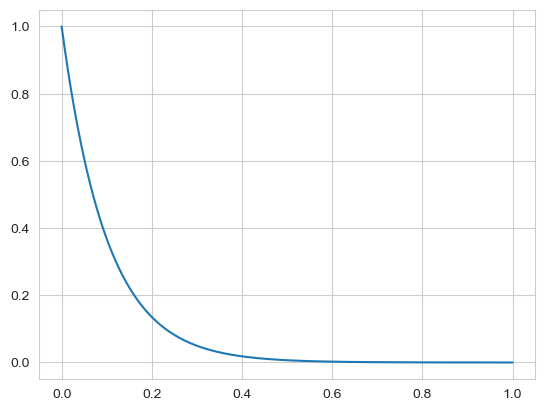

In [174]:

def agn_fraction(a,b,f):
    return a * np.exp(-f/b)

x_model = np.linspace(0,1,1000)
y_model = agn_fraction(1, 0.1, x_model)

plt.plot(x_model, y_model)

Text(0, 0.5, 'Number of Objects')

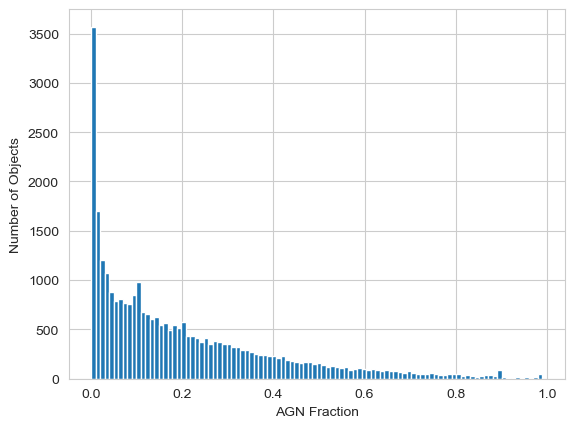

In [175]:
agn_per_dir = f'inputs/cdfs_agn_frac.txt'
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')
plt.clf()
bins_count = 100
(n, bins, patches) = plt.hist(all_bayes['bayes.agn.fracAGN'], bins=bins_count, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')

C:\Users\eddie\AppData\Local\Temp\ipykernel_26200\3926355739.py:4: RuntimeWarning: invalid value encountered in log10
  return a * np.log10(b * x + c) + d


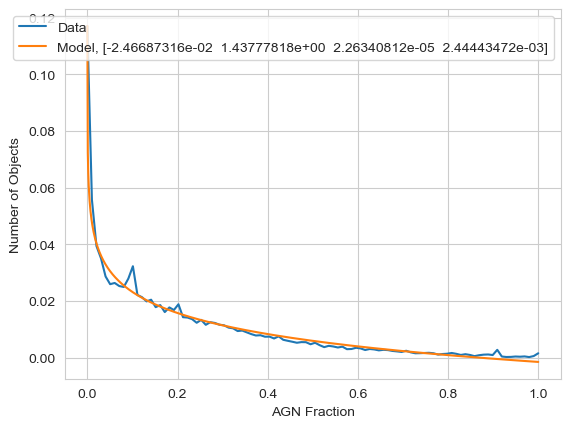

In [176]:
from scipy.optimize import curve_fit

def log(x,a,b,c,d):
    return a * np.log10(b * x + c) + d

x_data = np.linspace(0,1,int(bins_count))
y_data = n / n.sum()
popt, pcov = curve_fit(log, x_data, y_data, p0=[-0.05, 1, 0.0005, 0])

x_mdoel = np.linspace(0,1,1000)
y_model = log(x_model, *popt)

plt.plot(x_data, y_data, label='Data')
plt.plot(x_model, y_model, label=f'Model, {popt}')
plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.legend()


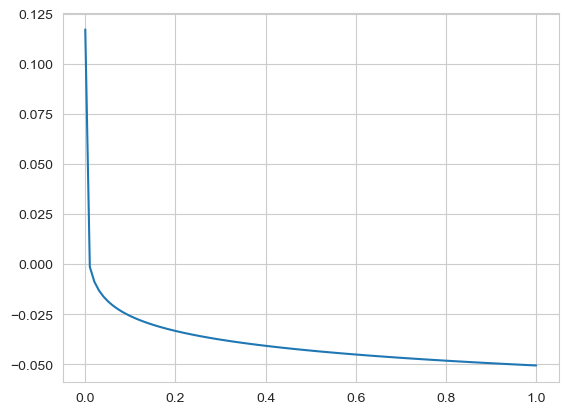

In [177]:
def agn_fractioner(fraction):
    # combined templates based on the given fraction.
    print('ok')

fraction_per = []
for i in range(bins_count):
    fraction_per.append(log(i, *popt))
plt.plot(x_data, fraction_per)

In [193]:
# randomiser

def randomiser(function=log, inputs=None, ncontrol=10**6, size=0):
    samples = []
    loop_no = 0
    while len(samples) < size and loop_no < ncontrol:
        loop_no += 1
        sample = np.random.rand()
        if np.random.rand() < function(sample, *inputs):
            samples.append(sample)

    return samples



(array([261., 159., 204., 163., 158., 140., 136., 133., 121., 126., 122.,
        114., 109., 114., 105., 102., 105.,  97., 103., 113.,  78.,  77.,
         79.,  85.,  80.,  75.,  74.,  66.,  72.,  77.,  89.,  69.,  83.,
         76.,  72.,  80.,  79.,  68.,  80.,  78.,  75.,  53.,  70.,  63.,
         73.,  59.,  51.,  62.,  58.,  79.,  65.,  58.,  60.,  45.,  50.,
         57.,  51.,  69.,  58.,  50.,  54.,  49.,  47.,  31.,  38.,  58.,
         54.,  47.,  40.,  39.,  53.,  48.,  52.,  57.,  42.,  49.,  55.,
         41.,  46.,  46.,  34.,  49.,  43.,  38.,  36.,  42.,  41.,  39.,
         41.,  30.,  38.,  41.,  43.,  42.,  37.,  30.,  35.,  28.,  39.,
         44.,  25.,  29.,  41.,  29.,  35.,  27.,  30.,  28.,  34.,  34.,
         28.,  29.,  29.,  31.,  31.,  32.,  29.,  49.,  18.,  25.,  26.,
         20.,  20.,  29.,  21.,  21.,  30.,  29.,  26.,  23.,  21.,  21.,
         25.,  20.,  16.,  20.,  14.,  29.,  18.,  22.,  19.,  21.,  17.,
         24.,  20.,  22.,  19.,  24., 

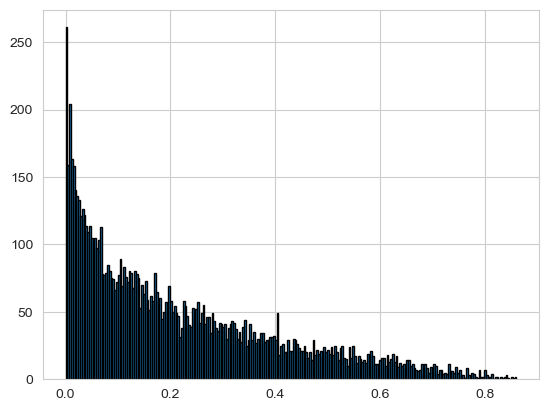

In [198]:
no_of_galaxies = 10000

agn_fractions = randomiser(log, inputs=[*popt], size=no_of_galaxies)

plt.hist(agn_fractions, bins=250, edgecolor='black')

In [184]:
np.random.uniform(low=0,high=1)

0.20917831737767767